# Fitting the Ringdown of GW150914  to a Sum of Exponentials
## Don MacMillen

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

The recent discovery of the gravity wave \[1\] from a binary black hole merger makes for exciting times in Astronomy and Physics.  Even better, all of the data and much of the analysis has been [made open](https://losc.ligo.org/s/events/GW150914/GW150914_tutorial.html) so that even amateurs like me can have fun partying on it.

First a quick overview. The gravity wave GW150914 consists of three regimes.  First is due to the in-spiral, where the binary black hole system is spiraling in ever closer together.  Here both the amplitude and the frequency are increasing on the way to the merger.  The second phase is the merger, when the holes coalese into one.  This corresponds to roughly the peak of the waveform. Finally the perturbed combined black hole goes through a damped oscillation as it relaxes back to a ground state and this is called the ringdown. The ringdown is expected to be composed of quasi normal waves of the combined black hole.  They are called quasi because they are heavily damped. It is this part of the waveform that we would like to fit with a sum of complex exponentials.

Fitting sums of exponentials has a long history and it turns out that it can be very difficult to do so. The difficulty arises when we have a real component to one (or many) of the exponential parameters which means we either have an damped or amplified component in the sum.  When a fitting routine or optimizer is searching parameter space for the best fit, it can be in a regime where only one term of the sum is effectively contributing to the objective function.  Bad things can happen here, since the residual error seems to be independent of many of the parameters we are trying to fit.

One technique \[2\] used in the gravity wave community \[3\] goes by the name of [Prony's method](https://en.wikipedia.org/wiki/Prony%27s_method) and has origins dating back to 1795. More recent work \[4\] uses a method named greedy-OLS (greedy ordinary linear least squares) and can be seen [here](http://arxiv.org/pdf/1404.3197.pdf).

We are going to take a different approach and use an algorithm called Varpro \[5\].  This algorithm uses the observation that many nonlinear least squares problems that also include linear parameters are **separable**.  That is, the model has both linear and nonlinear parameters that appear in a particular way.  The residual vector is given by the data minus the model at the m sampled points.  For a separable problem, we can write that vector as [6]

$$ r_i (\textbf{a}, \boldsymbol\alpha) = y_i - \sum_{j=1}^n a_j * \phi(\boldsymbol\alpha; t_i) $$

where $\textbf{a}$ is the vector of linear parameters and $\boldsymbol\alpha$ is the vector of nonlinear parameters.

The insight used by Varpro is that the problem of minimizing the square sum of the residuals is that it can be recast into another problem that eliminates the linear variables while the maintaining the same solution for the nonlinear variables.  One then solves the recast problem using a standard nonlinear least squares solver that needs to consider only the nonlinear variables.  When these are found, they are then used in the final **linear** least squares solutuon for the linear variables $\textbf{a}$

So we note that our sum of complex exponentials is exactly in the form of the equation given above.  This makes Varpro an great approach to this problem as is evidenced by the recent book on exponential data fitting \[7\].  A recent excellent exposition of many of the approaches to exponential data fitting is the applied mathematics [thesis](http://www.caam.rice.edu/tech_reports/2014/TR14-02.pdf) in [8] by Hokanson.

The version of Varpro that we will use is a Julia translation of the Matlab version by [O'Leary and Rust](http://www.cs.umd.edu/~oleary/software/varpro.pdf) \[9\].  The Julia version can be found at https://github.com/macd/Varpro.jl. Besides being translated in Julia, this version has also been extended to handle complex residual vectors with complex nonlinear parameters.  Also, this version of Varpro uses a "golden oldie" for the nonlinear least squares solver: NL2SOL \[10\] \[11\].  The reason for that is that this optimization routine has proven to be very robust compared to Levenberg Marquardt, especially in the large residual and/or bad initial guess regime.  The original FORTRAN code has been wrapped using Julia's metaprogramming and interface features so that it can be called directly from Julia and can directly use Julia functions for the gradient and jacobian.  It can be found at https://github.com/macd/NL2sol.jl. 

One of the helpful features used in the search for gravity waves is that the Astronomers and Physicist involved knew what to look for. That is because many binary black hole mergers have been simulated with [numerical relativity](https://en.wikipedia.org/wiki/Numerical_relativity).
Below we load and plot the results from a numerical relativity simulation that is thought to best match GW150914.

In [1]:
using PyPlot

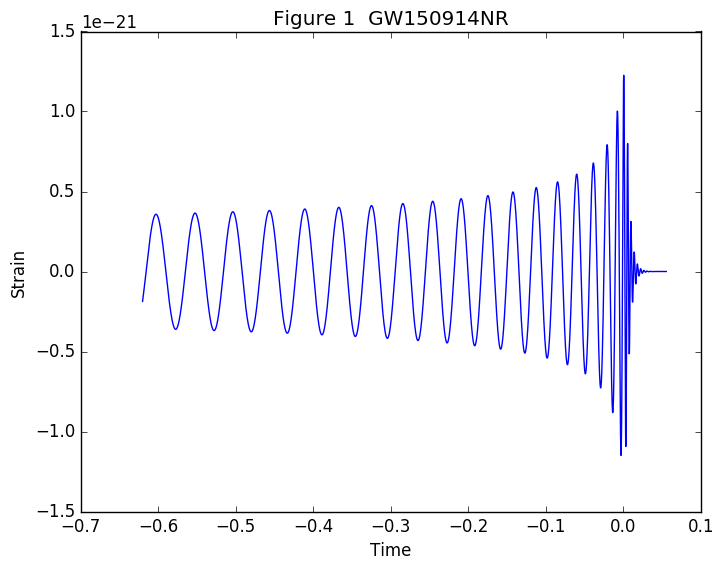

PyObject <matplotlib.text.Text object at 0x7f099b756860>

In [3]:
nrgw = readdlm("data/GW150914_4_NR_waveform.txt")
pg = plot(nrgw[:,1], nrgw[:,2])
title("Figure 1  GW150914NR")
xlabel("Time")
ylabel("Strain")

We will take the t = 0.0 point as the beginning of the ringdown.  Here is what it looks like.

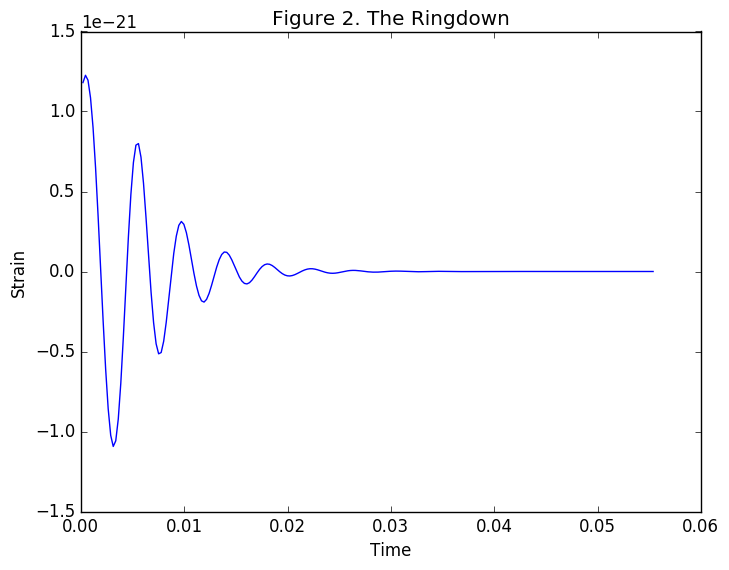

PyObject <matplotlib.text.Text object at 0x7f099b2cc128>

In [4]:
nrrd = nrgw[nrgw[:, 1] .>= 0.0, :]
plot(nrrd[:,1], nrrd[:,2])
title("Figure 2. The Ringdown")
xlabel("Time")
ylabel("Strain")

As you can see, it is heavily damped.  While this is an appealing figure, it is hard to see the oscillations beyond about t = 0.025.  Therefore we will switch to viewing the log(abs(y))

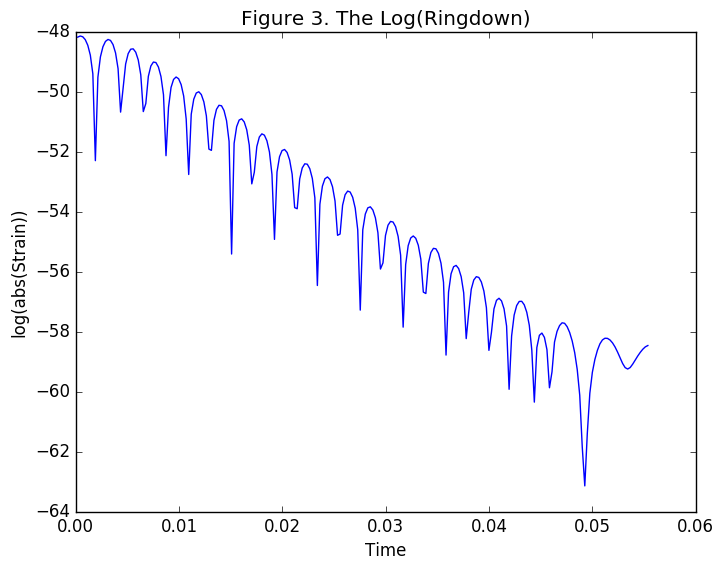

PyObject <matplotlib.text.Text object at 0x7f099b369f60>

In [5]:
plot(nrrd[:,1], log(abs(nrrd[:,2])))
title("Figure 3. The Log(Ringdown)")
xlabel("Time")
ylabel("log(abs(Strain))")

Now we can clearly see the oscillations all the way out to the limits of the data.

As this is our example of a "perfect" waveform, we will spend some time experimenting with the modeling before tackling waveforms with measurement noise. (Well, it is also possible that this waveform has noise too: numerical noise and that looks possible out past t = 0.04).

We first set up the calculation of the phi and dphi [9] matrices which roughly correspond to the gradient and the jacobian.

In [6]:
using Varpro

function f_exp(alpha, ctx)
    for i in 1:ctx.m
        for j = 1:ctx.n
            ctx.phi[i, j] = exp(-alpha[j] * ctx.t[i])
        end
    end
    ctx.phi
end

function g_exp(alpha, ctx)
    for i in 1:ctx.m
        ctx.dphi[i, :] = -ctx.t[i] * ctx.phi[i, :]
    end
    ctx.dphi
end

""" Fit n complex exponentials to the measured data """
function exp_fit(n, y, t; verbose=true)
    w = ones(length(t))                           # weighting vector
    ind = [collect(1:n)'; collect(1:n)']          # structure of dphi matrix
    x_init = complex([1.,1,2,2,3,3,4,4], [1.,-1,2,-2,3,-3,4,-4])   # here is magic
    ctx = FitContext(y, t, w, x_init[1:n], n, ind, f_exp, g_exp)   # create FitContext
    ctx.verbose = verbose
    ctx.mxfcal = 500                              # new value for NL2sol's max function calls
    ctx.mxiter = 500                              # new value for NL2sol's max iterations
    (alpha, c, wresid, resid_norm, y_est, regression) = varpro(ctx)
end

  likely near /home/ubuntu/.julia/v0.5/Lexicon/src/compat.jl:106
  likely near /home/ubuntu/.julia/v0.5/Lexicon/src/query.jl:216


exp_fit

We can now peform a waveform fit the NR ringdown template.  Note the scale on the above graph which is 1e-21, which is very small.  It turns out that scaling does matter here, so we scale up all the waveforms by a factor that makes the maximum of the NR ringdown template 10.0

In [7]:
scale = 10.0 / maximum(abs(nrrd[:, 2]))
t_nr = nrrd[:, 1]
y_nr = complex(scale * nrrd[:, 2])  # must be complex when x_init is complex
x, c, resid, resid_norm, y_est, reg = exp_fit(1, y_nr, t_nr)
println("Norm of residual error: ", resid_norm)
@show(x)
@show(c)


NL2sol return code: both x and relative function convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [1.0,1.0]
 * Minimizer: [194.6472162114437,-1326.4254143482647]
 * Minimum: 277.079335
 * Iterations: 23
 * Convergence: true
   * |x - x'| < 7.4e-09: true
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: false
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 29
 * Gradient Calls: 24
 
VARPRO Results:
 Linear Parameters: Complex{Float64}[4.6131742318019455 - 6.326182100487062im]
 Nonlinear Parameters: Complex{Float64}[194.6472162114437 - 1326.4254143482647im]
 Norm-squared of weighted residual  = 277.07933473989505
 Norm-squared of data vector        = 1179.3130854489493
 Norm         of weighted residual  = 16.64570018773302
 Norm         of data vector        = 34.34112819126578
 Expected error of observations     = 1.109713345848868 + 0.0im
 Coefficient of determination       = 0.7647156011

1-element Array{Complex{Float64},1}:
 4.61317-6.32618im

So a single exponential doesn't do all that well (norm of residual ~ 17). Here is what it looks like on a log scale.

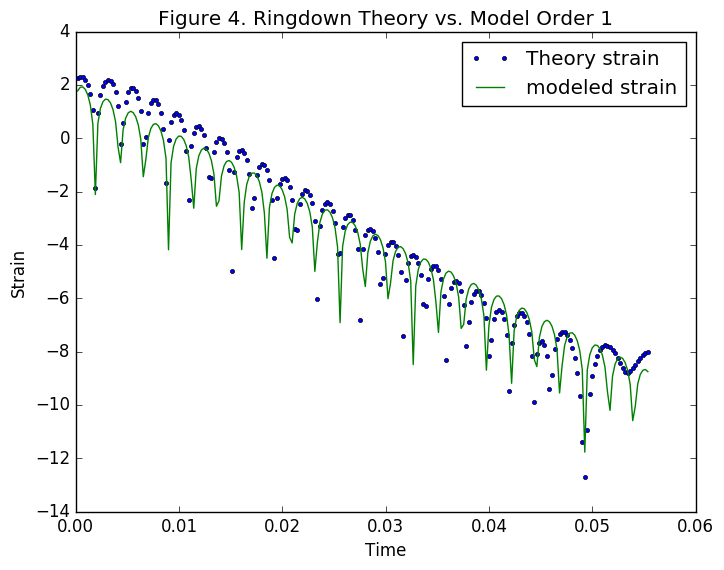

In [8]:
plot(t_nr, log(abs(real(y_nr))), "o", markersize=3.0, label="Theory strain")
plot(t_nr, log(abs(real(y_est))), label="modeled strain")
xlabel("Time")
ylabel("Strain")
title("Figure 4. Ringdown Theory vs. Model Order 1")
legend(loc="upper right")
show()

So lets calculate the results for fitting orders 1 through 8 and see what we can learn

In [9]:
xx = []; cc = []; rr = []; yy_est = []
for i = 1:8
    x, c, resid, resid_norm, y_est, reg = exp_fit(i, y_nr, t_nr)
    push!(xx, x); push!(cc, c); push!(rr, resid_norm); push!(yy_est, y_est)
end

Warning from VARPRO:
   The linear parameters are currently not well-determined.
   The rank of the matrix in the subproblem is 1
   which is less than the 3 linear parameters.
Warning from VARPRO:
   The linear parameters are currently not well-determined.
   The rank of the matrix in the subproblem is 1
   which is less than the 3 linear parameters.

NL2sol return code: both x and relative function convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [1.0,1.0,2.0,2.0,1.0,-1.0,2.0,-2.0]
 * Minimizer: [187.84045396665053,187.84045076681696, ...]
 * Minimum: 0.651587
 * Iterations: 14
 * Convergence: true
   * |x - x'| < 7.8e-09: true
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: false
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 23
 * Gradient Calls: 15

   The linear parameters are currently not well-determined.
   The rank of the matrix in the subproblem is 1
   which is less than the 

In [10]:
using Formatting

function pcmplx(x, c)
    for i in 1:length(x)
        printfmt("   x[{}] {:13.6e}  {:13.6e}im    c[{}] {:13.6e}  {:13.6e}im\n",
                 i, real(x[i]), imag(x[i]), i, real(c[i]), imag(c[i]))
    end
end

for i = 1:8
    printfmt("\nModel Order {}\n", i)
    println("Norm of residual error: ", rr[i])
    println("Imaginary part of y_est: ", sum(abs(imag(yy_est[i]))))
    pcmplx(xx[i], cc[i])
end


Model Order 1
Norm of residual error: 16.64570018773302
Imaginary part of y_est: 98.30593090210745
   x[1]  1.946472e+02  -1.326425e+03im    c[1]  4.613174e+00  -6.326182e+00im

Model Order 2
Norm of residual error: 5.642688582584586
Imaginary part of y_est: 3.978259788426521e-10
   x[1]  1.573650e+02  -1.367284e+03im    c[1]  2.786697e+00  -5.676483e+00im
   x[2]  1.573650e+02   1.367284e+03im    c[2]  2.786697e+00   5.676483e+00im

Model Order 3
Norm of residual error: 4.4761723964370645
Imaginary part of y_est: 33.37357221180557
   x[1]  2.789034e+02   1.224594e+03im    c[1]  6.867362e+00   7.375073e-01im
   x[2]  1.541610e+02   1.534287e+03im    c[2] -3.399563e+00   2.783899e+00im
   x[3]  1.599260e+02  -1.349882e+03im    c[3]  3.346275e+00  -5.442583e+00im

Model Order 4
Norm of residual error: 0.8072093585049626
Imaginary part of y_est: 5.757084486519314e-7
   x[1]  1.878405e+02  -1.521979e+03im    c[1] -5.267854e+00  -4.630882e+00im
   x[2]  1.878405e+02   1.521979e+03im    c[2

Since we are fitting a real function with a set of complex linear and complex nonlinear parametes, we see the optimizer trying to find pairs of complex conjugates for the individual terms in the exponential expansion so that the imaginary parts will cancel out.  It can only do this effectively for even model orders and we can see that on some of the odd order models there is a substantial imaginary part to the estimated waveform.

There might be a fix for this, but before we do that, let's plot the last model generated against the data from the NR simulation.

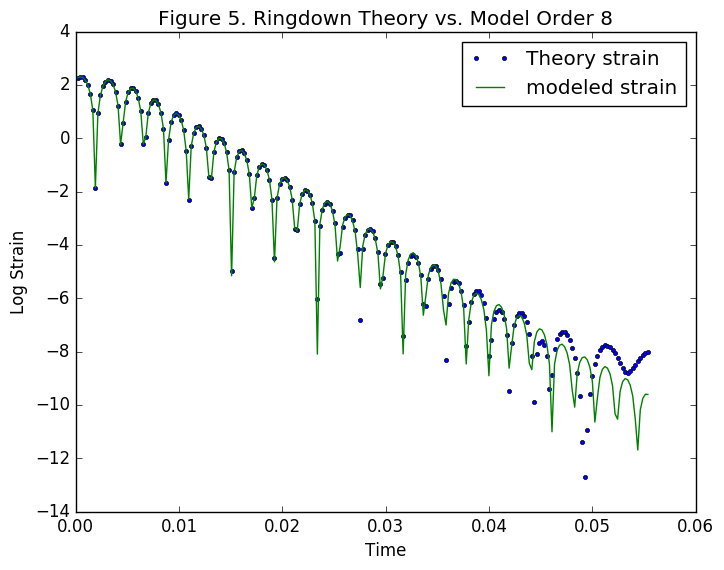

In [11]:
plot(t_nr, log(abs(real(y_nr))), "o", markersize=3.0, label="Theory strain")
plot(t_nr, log(abs(real(yy_est[8]))), label="modeled strain")
xlabel("Time")
ylabel("Log Strain")
title("Figure 5. Ringdown Theory vs. Model Order 8")
legend(loc="upper right")
show()

Which actually looks pretty good and has a residual norm of only 0.012467.  Let's look at the components separately (but in conjugate pairs) to understand the solution better.

In [12]:
# A hack
import Base: isless
function isless(x::Complex, y::Complex)
    return abs(x) < abs(y)
end

idx = sortperm(x)

x = x[idx]
c = c[idx]

function wave!(y, x, c, t)
    for i in length(y)
        y[i] = zero(Complex)
        for j in length(x)
            y[i] += c[j] * exp(-x[j] * t[i])
        end
    end
end

y = zeros(Complex, length(t_nr))

for i = 1:2:8
    wave!(y, x[i:i+1], c[i:i+1], t_nr)
    plot(t_nr, log(abs(real(y))), label="Component $i")
end

xlabel("Time")
ylabel("Log Strain")
title("Figure 6. Model Components")
legend(loc="upper right")
show()

LoadError: LoadError: MethodError: no method matching log(::Array{Any,1})
while loading In[12], in expression starting on line 23

The fix to our problem of optimizing more than we need to and getting possibly inferior results, we are going to do a change of representation to what is called the **complex analytic signal** \[12\] \[13\] (especially see Chapter 3 of reference \[13\]).

The real waveform as a function of complex parameters cannot be analytic in the complex plane. (If **gw = u + i \* v** and **gw** is real, then **v** must be zero and then the Cauchy-Riemann equations are not valid). So the recipe is one of adding an imaginary part, **i \* v**, to the gravity wave in order to make it an analytic signal.  Of course the **v** that we need to add cannot be arbitrary, since **u** and **v** must satisfy Cauchy-Riemann.

It turns out that **u** and **v** are intimately connected, since they must form Hibert transform pairs. If we write **i \* gi(t)** as the t parameterization of the imaginary part we are seeking (**gi(t)** is real) then the relationship that holds is:

$$ gi(t) = \frac{1}{\pi} \boldsymbol{P} \int_{-\infty}^{\infty} \frac{gw(t')}{t' - t} dt'$$

$$ gw(t) = - \frac{1}{\pi} \boldsymbol{P} \int_{-\infty}^{\infty} \frac{gi(t')}{t' - t} dt'$$

where $\boldsymbol{P}$ denotes the Cauchy principal value. The complex analytic signal is then defined as:

$$ z(t) = \frac{1}{2} (gw(t) + i * gi(t)) $$

It can be shown \[13\] that this only includes contributions from positive frequencies, which is exactly our goal.  The calculation is then to take the fft of gw, zero out the negative frequencies, and then perform the inverse fft.

Enough of the math!  Let's calculate the complex analytic signal and see how good it is.

In [ ]:
function analytic_signal(y)
    fty = fft(y)
    fty[1:div(length(y), 2)] = zero(Complex)
    z = ifft(2*fty)
end

z = analytic_signal(complex(y_nr))
plot(t_nr, y_nr, label="NR waveform")
plot(t_nr, real(z), label="real(z)")
plot(t_nr, imag(z), label="imag(z)")

So we do see that the real part of the analytic signal z matches (mostly) our original gravity wave ringdown. But the imaginary part is ugly, particularly at the longer times. Can the higher resolution data do better? Unfortunately, while the experimental data exists at higher sampling rates, I did not find any for the NR simulations. 

So let's just close our eyes and give it a go, but we will cut off the waveforms for t > 0.03  We will use order 4 here because that should match the order 8 model when we are only fitting the real signal.

But before that, we need to talk about the initial guess for the optimizer.

In [ ]:
pcmplx(x, c)
plot(t_nr, log(abs(y_nr)), label="NR waveform")
plot(t_nr, log(abs(real(y_est))), label="real(z)")
show()

In [ ]:
min_resid = 100.0
error_count = 0
for i = 1:100
    x, c, resid, resid_norm, y_est, reg =  try
        exp_fit(4, z, t_nr; verbose=false, init=random);
    catch
        error_count += 1
    end
    if resid_norm < min_resid
        min_resid = resid_norm
        println(min_resid)
    end
end
println("error count", error_count)


The Jupyter notebook mentioned above walks us through all the signal processing necessary to extract the gravity wave signals.  I have used that notebook to dump out some relevant filtered waveform files over the time frame of the ringdown. They are

  | File name | data vector | time range |
  |:---------:|:---------:|:-----------:|
  | h1_filtered.txt | strain_H1_filt |0 < t < .057 |
  | l1_filtered.txt | strain_L1_fils | 0 < t < .057 |
  | theory_filtered.txt | NR_H1_filt | 0 < t < .057 |

  
and they are quite a bit more messy than the beautiful waveform above.  Looking at the ringdown for both the L1 and H1 detectors, we see the following.

In [ ]:
h1f = readdlm("data/h1_filtered.txt")
l1f = readdlm("data/l1_filtered.txt")
tf = readdlm("data/theory_filtered.txt")

plot(h1f[:, 1], h1f[:, 2], "b", label="H1 strain")
plot(l1f[:, 1], l1f[:, 2], "r", label="L1 strain")
plot(tf[:, 1], tf[:, 2], "g", label="Theory (filtered)")
title("Figure 4. Filtered Ringdown of GW150914")
legend(loc="upper right")
xlabel("Time")
ylabel("Filtered strain")

## References

[1] B. Abbott et al., **Observation of Gravitational Waves from a Binary Black Hole Merger**, Phys. Rev. Lett. 116, 061102 (2016), https://dcc.ligo.org/LIGO-P150914/public/main

[2] M. R. Osborne and G. K. Smyth, **A modied prony algorithm for exponential function fitting**," SIAM Journal of Scientic Computing, vol. 16, pp. 119-138, 1995.

[3] E.  Berti,  V.  Cardoso,  J.  A.  Gonzalez,  and  U.  Sperhake,  **Mining  information  from binary black hole mergers: a comparison of estimation methods for complex exponentials in noise**," Phys. Rev. D, vol. 75, p. 124017, 2007.

[4] L. London, D. Shoemaker, J. Healy, **Modeling ringdown: Beyond the fundamental quasinormal modes**, Phys. Rev. D, vol. 90, 2014

[5] G. H. Golub and V. Pereyra, **The Differentiation of pseudo-inverses and nonlinear least squares problems whose variables separate**, SIAM J. Numer Anal, vol. 10, pp. 413-32, 1973

[6] G. Golub and V. Pereyra, **Separable nonlinear least squares: the variable projection method and its applications"**, Inverse Problems 19 (2), R1–R26 2003

[7] V. Pereyra and G. Scherer, **Exponential Data Fitting and Its Applications**, Bentham Books, ISBN: 978-1-60805-048-2, 2010

[8] J. Hokanson, **Numerically Stable and Statistically Efficient Algorithms for Large Scale
Exponential Fitting** Rice University, 2013

[9] D.P. O'Leary and B.W. Rust, **Variable Projection for Nonlinear Least Squares Problems**,
Computational Optimization and Applications April 2013, Volume 54, Issue 3, pp 579-593

[10] J.E. Dennis, D.M. Gay, R.E. Welsch, **An Adaptive Nonlinear Least-Squares Algorithm**, ACM Transactions on Mathematical Software (TOMS), Volume 7 Issue 3, Sept. 1981, pp 348-368, ACM New York, NY, USA

[11] J.E. Dennis, D.M. Gay, R.E. Welsch, **Algorithm 573: NL2SOL—An Adaptive Nonlinear Least-Squares Algorithm**, ACM Transactions on Mathematical Software (TOMS), Volume 7 Issue 3, Sept. 1981, pp 369-383, ACM New York, NY, USA

[12] D. Gabor, [**Theory of Communication, Part 1**](http://www.csee.wvu.edu/~xinl/library/papers/physics/gabor1946.pdf), J. Inst. of Elect. Eng. Part III, Radio and Communication, vol 93, p. 429 1946

[13] L. Mandel and E. Wolf, **Optical Coherence and Quantum Optics**, Cambridge University Press, ISBN 0 521 41711 2, Cambridge UK, 1995

[14]  D. Asenjo, J.D. Stevenson, D.J. Wales, D. Frenkel, **[Visualizing Basins of Attraction for Different Minimization Algorithms](http://arxiv.org/pdf/1309.7845.pdf)**, J. Phys. Chem. B, vol. 117, pp. 12717−12723, 2013